In [10]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import randint

In [3]:
# Print all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [4]:
# Load part of the train data
csv_files = ["ctr_15.csv", "ctr_16.csv", "ctr_17.csv", "ctr_18.csv", "ctr_19.csv", "ctr_20.csv", "ctr_21.csv"]
samples = []
porcentaje_datos = 0.1

print("Loading data...")
for file in csv_files:
    # Leer el archivo CSV
    df = pd.read_csv(file)
    
    # Tomar una muestra aleatoria del porcentaje definido
    sample = df.sample(frac=porcentaje_datos, random_state=1234)
    
    # Agregar el sample a la lista
    samples.append(sample)
    del df
    gc.collect()

train = pd.concat(samples, ignore_index=True)

Loading data...


In [5]:
# Load the test data
testeo = pd.read_csv("ctr_test.csv")

In [7]:
# Resumen estadístico para variables numéricas
print(train.describe())

               Label    auction_age  auction_bidfloor  auction_time  \
count  864459.000000  174779.000000     864459.000000  8.644590e+05   
mean        0.012202      31.044370          0.518898  1.516300e+09   
std         0.109786       9.865463          1.009598  1.786528e+05   
min         0.000000      -1.000000          0.000000  1.515975e+09   
25%         0.000000      25.000000          0.090000  1.516136e+09   
50%         0.000000      29.000000          0.170000  1.516310e+09   
75%         0.000000      36.000000          0.590000  1.516461e+09   
max         1.000000     124.000000         39.220000  1.516580e+09   

       creative_height  creative_width  timezone_offset  
count    732359.000000   732359.000000    863638.000000  
mean        132.236351      319.948588         1.806904  
std         127.404864       45.674991         1.885873  
min          50.000000      300.000000         1.000000  
25%          50.000000      300.000000         1.000000  
50%         

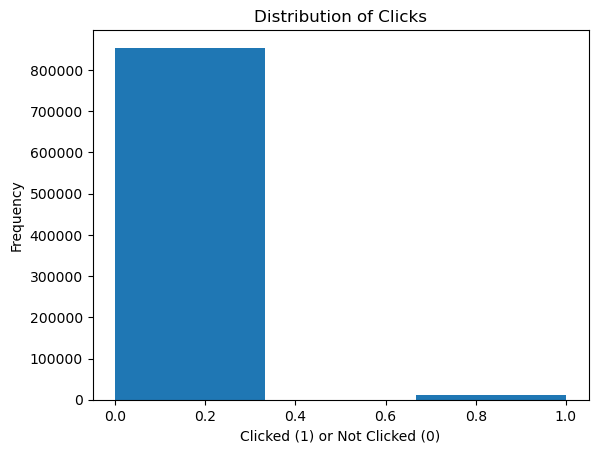

In [13]:
plt.hist(train['Label'], bins=3)
plt.xlabel('Clicked (1) or Not Clicked (0)')
plt.ylabel('Frequency')
plt.title('Distribution of Clicks')
plt.show()

In [9]:
# Frecuencia de variables categóricas
print(train[['action_categorical_0']].value_counts())

action_categorical_0
9915ffee                225076
11b7af3d                190629
c2e4f717                150196
604d011f                142154
e350c7c7                 80243
c202ab08                 51558
6b5513a4                 14790
7f02cacc                  6881
c186959e                  2932
Name: count, dtype: int64


In [5]:
# Identificar las columnas numéricas y categóricas
print("Identifying columns...")
categorical_columns = train.select_dtypes(include=['object']).columns
numerical_columns = train.select_dtypes(include=['number']).columns

Identifying columns...


In [6]:
# Train a tree on the train data
print("Separando X e Y...")
X = train.drop('Label', axis=1)
y = train['Label']

print("Splitting data en validation and training...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234)

Separando X e Y...
Splitting data en validation and training...


In [7]:
# Crear el ColumnTransformer para aplicar OneHotEncoder a las columnas categóricas y SimpleImputer a las numéricas
numerical_columns = train.select_dtypes(include=['number']).columns.difference(['Label'])
categorical_columns = train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

In [8]:
# Definir el modelo y la pipeline
pipeline = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=2345))

# Definir el espacio de hiperparámetros
param_dist = {
    'decisiontreeclassifier__max_depth': randint(1, 30),
    'decisiontreeclassifier__min_samples_split': randint(2, 100),
    'decisiontreeclassifier__min_samples_leaf': randint(1, 100)
}

# Implementar RandomizedSearchCV
print("Implementing RandomizedSearchCV...")
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=5, scoring='roc_auc', random_state=1234, cv=3, verbose=1, error_score='raise')

print("Fitting the model...")
# Ajustar el modelo con los mejores hiperparámetros
random_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor AUC
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best AUC score: {best_score:.2f}")

Implementing RandomizedSearchCV...
Fitting the model...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [ ]:
# Predecir en el conjunto de validación
y_test_probs = random_search.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_test_probs)

print(f"AUC on validation set: {roc_auc:.2f}")

In [ ]:
# Predecir en el conjunto de testeo
y_preds = random_search.predict_proba(testeo.drop(columns=["id"]))[:, 1]


In [ ]:
# Make the submission file
submission_df = pd.DataFrame({"id": testeo["id"], "Label": y_preds})
submission_df["id"] = submission_df["id"].astype(int)
submission_df.to_csv("rand_search_ohe.csv", sep=",", index=False)